In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D

In [14]:
excel_path = 'Hetero_Data.xlsx'
df = pd.read_excel(excel_path)

In [15]:
print(df.shape)
df.head()

(213, 340)


,time,time.1,time.2,time.3,time.4,time.5,time.6,time.7,time.8,time.9,...,time.330,time.331,time.332,time.333,time.334,time.335,time.336,time.337,time.338,Original
0,1,1.038189,1.059892,1.034006,1.023853,1.028510,1.030863,1.035258,1.039198,1.042250,...,1.029452,1.019635,1.013665,1.012057,1.018319,1.033108,1.030647,1.020431,1.013621,1
1,1,1.042940,1.067785,1.040393,1.029157,1.033387,1.036497,1.042586,1.049073,1.053859,...,1.035474,1.040027,1.044808,1.045222,1.049973,1.062408,1.053485,1.035657,1.023771,1
2,1,1.050455,1.081516,1.056593,1.046919,1.048408,1.050272,1.052385,1.058426,1.062399,...,1.033852,1.024401,1.016267,1.010845,1.020747,1.049803,1.058463,1.052934,1.038534,1
3,1,1.051986,1.080560,1.041552,1.029965,1.039257,1.045918,1.055883,1.066993,1.073642,...,1.354359,1.328754,1.297513,1.242373,1.183352,1.129709,1.089348,1.059565,1.039710,1
4,1,1.042848,1.063593,1.020535,1.008532,1.022222,1.027057,1.033692,1.036392,1.036106,...,1.120878,1.095236,1.068684,1.047268,1.035145,1.033099,1.026046,1.017364,1.011576,1


In [16]:
# Counting the occurrences of each class in the specified column
column_name = 'Original'
value_counts = df[column_name].value_counts().sort_index()

# Display the counts
for value, count in value_counts.items():
    print(f'Count of {value}s: {count}')

classes = range(1, 5)

# Create a dictionary to store separate DataFrames for each class
dfs_by_class = {}

# Filter the data for each value and store in separate DataFrames
for value in classes:
    filtered_df = df[df[column_name] == value].head(52)
    dfs_by_class[value] = filtered_df

# # Access the separate DataFrames using the dictionary
# for cls, filtered_df in dfs_by_class.items():
#     print(f'DataFrame for {cls}s:')
#     print(filtered_df.head())
#     print('\n')

Count of 1s: 52
Count of 2s: 52
Count of 3s: 55
Count of 4s: 54


In [17]:
class DataFrameConverter:
    def __init__(self, dfs_by_class):
        self.dfs_by_class = dfs_by_class

    def convert_to_numpy(self):
        numpy_data_by_class = {}

        for cls, df in self.dfs_by_class.items():
            numpy_data = df.iloc[:, :-1].to_numpy()
            numpy_data_by_class[cls] = numpy_data

        return numpy_data_by_class

In [18]:
# Creating a DataFrameConverter instance
converter = DataFrameConverter(dfs_by_class)

# Converting DataFrames to NumPy arrays
numpy_data_by_class = converter.convert_to_numpy()

# # Accessing the NumPy arrays using the dictionary
# for cls, numpy_data in numpy_data_by_class.items():
#     print(f'NumPy array for class {cls}:')
#     print(numpy_data[:2])
#     print('\n')

In [19]:
class SlidingWindowProcessor:
    def __init__(self, window_size, step):
        self.window_size = window_size
        self.step = step

    def process_data(self, numpy_data):
        data_with_windows = []

        for row in numpy_data:
            samples_row = []
            for i in range(0, len(row) - self.window_size + 1, self.step):
                window = row[i:i + self.window_size]
                samples_row.append(window)
            data_with_windows.append(samples_row)

        return np.array(data_with_windows)

In [20]:
window_size = 10
step = 2

In [21]:
# Create an instance of SlidingWindowProcessor
window_processor = SlidingWindowProcessor(window_size, step)

np_data = {}

for i in range(1, 5):
    np_data[i] = window_processor.process_data(numpy_data_by_class[i])

print(np_data[4].shape)

(52, 165, 10)


In [22]:
class DataSplitter:
    def __init__(self, s1, s2, s3):
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.class_splitter = {}  # Dictionary to store splitters for each class

    def shuffle_and_split(self, data, cls_number):
        data_shuffled = shuffle(data, random_state=42)

        index1 = int(data_shuffled.shape[0] * self.s1)
        index2 = int(data_shuffled.shape[0] * (self.s1 + self.s2))

        x_train = data_shuffled[:index1]
        x_val = data_shuffled[index1:index2]
        x_test = data_shuffled[index2:]

        y_train = np.zeros((x_train.shape[0], 4))
        y_train[:, cls_number - 1] = 1

        y_val = np.zeros((x_val.shape[0], 4))
        y_val[:, cls_number - 1] = 1

        y_test = np.zeros((x_test.shape[0], 4))
        y_test[:, cls_number - 1] = 1

        # Save the split data for later concatenation
        self.class_splitter[cls_number] = (x_train, x_val, x_test, y_train, y_val, y_test)

        return x_train, x_val, x_test, y_train, y_val, y_test

    def splitter(self, data, cls_number):
        x_train, x_val, x_test, y_train, y_val, y_test = self.shuffle_and_split(data, cls_number)

        return x_train, x_val, x_test, y_train, y_val, y_test
    
    def concatenate_data(self):
        # Concatenate data from all classes
        x_train_concat = np.concatenate([split[0] for split in self.class_splitter.values()], axis=0)
        x_val_concat = np.concatenate([split[1] for split in self.class_splitter.values()], axis=0)
        x_test_concat = np.concatenate([split[2] for split in self.class_splitter.values()], axis=0)
        y_train_concat = np.concatenate([split[3] for split in self.class_splitter.values()], axis=0)
        y_val_concat = np.concatenate([split[4] for split in self.class_splitter.values()], axis=0)
        y_test_concat = np.concatenate([split[5] for split in self.class_splitter.values()], axis=0)

        return x_train_concat, x_val_concat, x_test_concat, y_train_concat, y_val_concat, y_test_concat
    
    def __str__(self):
        result = "DataSplitter class:\n"
        for cls_number, split_data in self.class_splitter.items():
            result += f"Class {cls_number}:\n"
            result += f"  x_train shape: {split_data[0].shape}\n"
            result += f"  x_val shape: {split_data[1].shape}\n"
            result += f"  x_test shape: {split_data[2].shape}\n"
            result += f"  y_train shape: {split_data[3].shape}\n"
            result += f"  y_val shape: {split_data[4].shape}\n"
            result += f"  y_test shape: {split_data[5].shape}\n"
            result += "\n"
        return result

In [23]:
p = DataSplitter(s1=0.7, s2=0.1, s3=0.2)

In [24]:
x_train, x_val, x_test, y_train, y_val, y_test= {}, {}, {}, {}, {}, {}

for i in range(1,5):
    x_train[i], x_val[i], x_test[i], y_train[i], x_val[i], y_test[i] = p.splitter(np_data[i], i)

In [25]:
print(p)

DataSplitter class:
Class 1:
  x_train shape: (36, 165, 10)
  x_val shape: (5, 165, 10)
  x_test shape: (11, 165, 10)
  y_train shape: (36, 4)
  y_val shape: (5, 4)
  y_test shape: (11, 4)

Class 2:
  x_train shape: (36, 165, 10)
  x_val shape: (5, 165, 10)
  x_test shape: (11, 165, 10)
  y_train shape: (36, 4)
  y_val shape: (5, 4)
  y_test shape: (11, 4)

Class 3:
  x_train shape: (36, 165, 10)
  x_val shape: (5, 165, 10)
  x_test shape: (11, 165, 10)
  y_train shape: (36, 4)
  y_val shape: (5, 4)
  y_test shape: (11, 4)

Class 4:
  x_train shape: (36, 165, 10)
  x_val shape: (5, 165, 10)
  x_test shape: (11, 165, 10)
  y_train shape: (36, 4)
  y_val shape: (5, 4)
  y_test shape: (11, 4)




In [26]:
x_train1, x_val1, x_test1, y_train1, y_val1, y_test1 = p.concatenate_data()

print(x_train1.shape)
print(x_val1.shape)
print(x_test1.shape)
print(y_train1.shape)
print(y_val1.shape)
print(y_test1.shape)
print(y_test1[:8])

(144, 165, 10)
(20, 165, 10)
(44, 165, 10)
(144, 4)
(20, 4)
(44, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [27]:
import random

indices_1 = list(np.arange(len(x_train1)))
random.shuffle(indices_1)
x_train = x_train1[indices_1]
y_train = y_train1[indices_1]

indices_2 = list(np.arange(len(x_val1)))
random.shuffle(indices_2)
x_val = x_val1[indices_2]
y_val = y_val1[indices_2]

indices_3 = list(np.arange(len(x_test1)))
random.shuffle(indices_3)
x_test = x_test1[indices_3]
y_test = y_test1[indices_3]

print(y_test[:8])

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [28]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, History, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [29]:
# Create a RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, input_shape = (165, 10), activation = 'relu', return_sequences = True))
rnn_model.add(SimpleRNN(32, activation = 'relu'))
rnn_model.add(Dense(4, activation = 'softmax'))
rnn_model.summary()

c:\Users\Kishore\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 165, 32)        │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,588 (14.02 KB)

 Trainable params: 3,588 (14.02 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Compile the model
rnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Create a ModelCheckpoint callback to save the best model
rnn_checkpoint = ModelCheckpoint("best_rnn_model_weights.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model with ModelCheckpoint callback
rnn_history = rnn_model.fit(x_train, y_train, epochs=1500, batch_size=4, validation_data=(x_val, y_val), callbacks=[rnn_checkpoint], verbose=1)

# Load the best model weights
rnn_model.load_weights("best_rnn_model_weights.keras")

# Save training history to a file
np.save('rnn_history', rnn_history.history)

# Evaluate the model on the test set
loss, accuracy, rmse = rnn_model.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test RMSE: {rmse:.4f}')

Epoch 1/1500
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2381 - loss: 1.5653 - rmse: 0.4557
Epoch 1: val_loss improved from inf to 1.40502, saving model to best_rnn_model_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.2378 - loss: 1.5581 - rmse: 0.4548 - val_accuracy: 0.2500 - val_loss: 1.4050 - val_rmse: 0.4358
Epoch 2/1500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2179 - loss: 1.4032 - rmse: 0.4356
Epoch 2: val_loss improved from 1.40502 to 1.38748, saving model to best_rnn_model_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2188 - loss: 1.4029 - rmse: 0.4355 - val_accuracy: 0.3000 - val_loss: 1.3875 - val_rmse: 0.4332
Epoch 3/1500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2663 - loss: 1.3832 - rmse: 0.4326
Epoch 3: val_loss improved from 1.38748 to 1.38522, saving model to best_rnn_model_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2662 - loss: 1.3833 - rmse: 0.4326 - val_accuracy: 0.

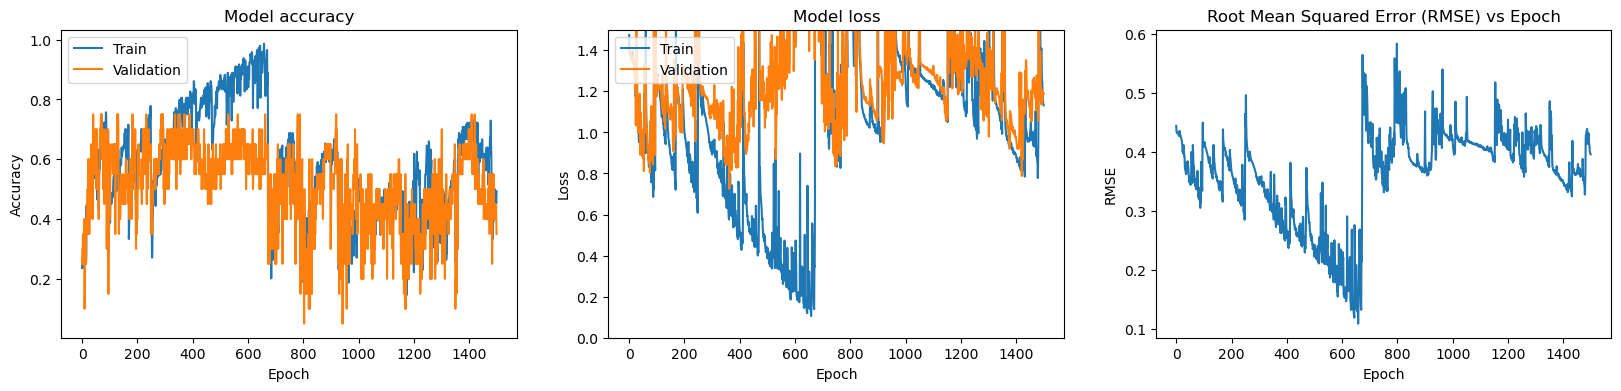

In [32]:
# Load the saved history
rnn_history = np.load('rnn_history.npy', allow_pickle='TRUE').item()

# Plot training & validation accuracy values
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.plot(rnn_history['accuracy'])
plt.plot(rnn_history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(rnn_history['loss'])
plt.plot(rnn_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 1.5)
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot RMSE vs epoch
plt.subplot(1, 3, 3)
plt.plot(rnn_history['rmse'])
plt.title('Root Mean Squared Error (RMSE) vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.show()

In [33]:
# Make predictions on the test set
y_pred = rnn_model.predict(x_test)
y_val_pred = rnn_model.predict(x_val)
y_train_pred = rnn_model.predict(x_train)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis = 1)
y_test_classes = np.argmax(y_test, axis = 1)
y_val_pred_classes = np.argmax(y_val_pred, axis = 1)
y_val_classes = np.argmax(y_val, axis = 1)
y_train_pred_classes = np.argmax(y_train_pred, axis = 1)
y_train_classes = np.argmax(y_train, axis = 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


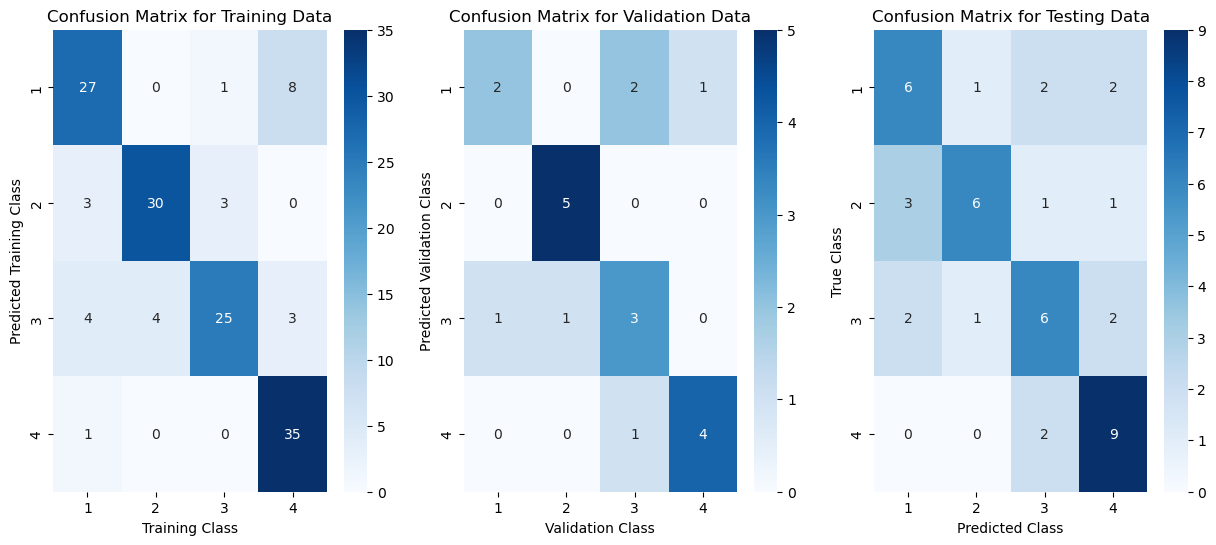

In [34]:
# Create a confusion matrix
conf_matrix_1 = confusion_matrix(y_train_classes, y_train_pred_classes)
conf_matrix_2 = confusion_matrix(y_val_classes, y_val_pred_classes)
conf_matrix_3 = confusion_matrix(y_test_classes, y_pred_classes)

# Visualize the confusion matrix for training data
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel('Training Class')
plt.ylabel('Predicted Training Class')
plt.title('Confusion Matrix for Training Data')

# Visualize the confusion matrix for validation data
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel('Validation Class')
plt.ylabel('Predicted Validation Class')
plt.title('Confusion Matrix for Validation Data')

# Visualize the confusion matrix for testing data
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_3, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [35]:
# Print accuracy and loss when the model performed best
best_epoch = np.argmin(rnn_history['val_loss'])
best_val_loss = rnn_history['val_loss'][best_epoch]
best_val_accuracy = rnn_history['val_accuracy'][best_epoch]

print(f'Best Epoch: {best_epoch + 1}, Best Validation Loss: {best_val_loss:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}')

Best Epoch: 363, Best Validation Loss: 0.7254, Best Validation Accuracy: 0.7000
